## Importing librairies

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from loading_data import *
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from math import sqrt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from scipy import stats
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm


In [3]:
!pip install pwlf

In [4]:
import pwlf

In [5]:
ncg_consumption, gaspool_consumption, the_consumption = read_consumption()
consumption_data = pd.concat([ncg_consumption.add(gaspool_consumption, fill_value=0), the_consumption])
df_consumption = consumption_data.to_frame(name='consumption')

# avoir le premier et le dernier index de la série
start_date = consumption_data.index[0].strftime("%Y-%m-%d")
end_date = consumption_data.index[-1].strftime("%Y-%m-%d")

weather = read_weather()
# afficher les colonnes du dataframe
print(weather.columns)
temp_2m_mean = weather["temperature_2m_mean (°C)"]
temp_2m_mean = temp_2m_mean[start_date:end_date] # avoir les dates des températures maximales à partir de start_date jusqu'à end_date


Index(['temperature_2m_max (°C)', 'temperature_2m_min (°C)',
       'temperature_2m_mean (°C)', 'sunshine_duration (h)',
       'wind_speed_10m_max (km/h)'],
      dtype='object')


In [6]:
temp_2m_mean

Date
2011-04-01    12.7
2011-04-02    14.3
2011-04-03    15.3
2011-04-04    10.6
2011-04-05    10.0
              ... 
2024-10-27    11.6
2024-10-28    11.8
2024-10-29    13.1
2024-10-30    12.9
2024-10-31    11.7
Name: temperature_2m_mean (°C), Length: 4963, dtype: float64

In [7]:
#Conso mensuelle
gas_consumption_monthly = df_consumption.resample('M').sum()
temp_2m_mean_monthly = temp_2m_mean.loc[start_date:end_date].resample('M').mean()


In [54]:
df_consumption

,consumption
2011-04-01,1233962.960
2011-04-02,1006977.403
2011-04-03,1025128.699
2011-04-04,1334227.003
2011-04-05,1362010.627
...,...
2024-10-27,1914459.771
2024-10-28,2186914.778
2024-10-29,2330071.796
2024-10-30,2312481.125


In [10]:
consumption_data.corr(temp_2m_mean)

-0.7536698980266934

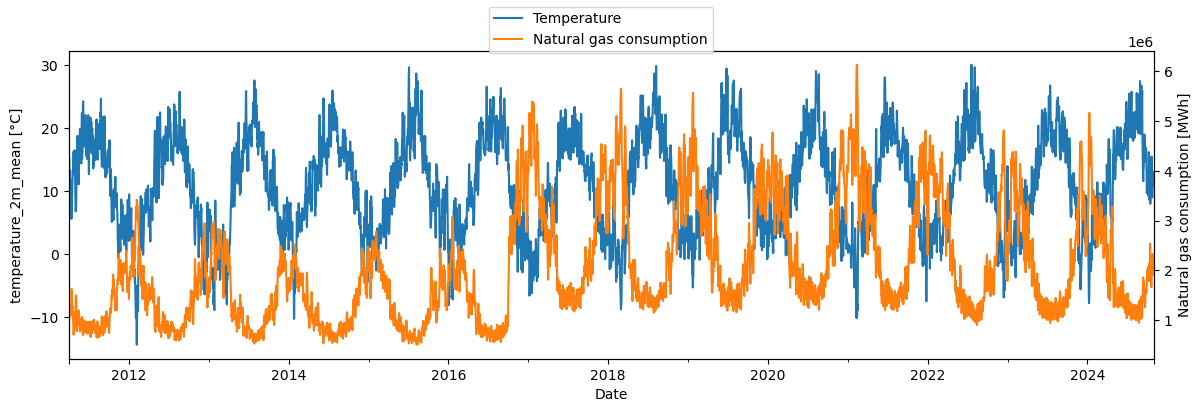

In [11]:
fig, ax1 = plt.subplots(figsize=(14, 4))
ax2 = ax1.twinx()

# For both, only show data in 2021 and 2022
temp_2m_mean.loc[start_date:end_date].plot(ax=ax1, color="tab:blue")
consumption_data.plot(ax=ax2, color="tab:orange")

# Labels and legend
ax1.set_ylabel("temperature_2m_mean [°C]")
ax2.set_ylabel("Natural gas consumption [MWh]")

# Legend for both plots in one
fig.legend(
    labels=["Temperature", "Natural gas consumption"],

    loc="upper center",
)

# Create directory if it does not exist
os.makedirs("diagrams", exist_ok=True)

# Save plot
fig.savefig("diagrams/temp_conso_daily.svg", format="svg", bbox_inches="tight")

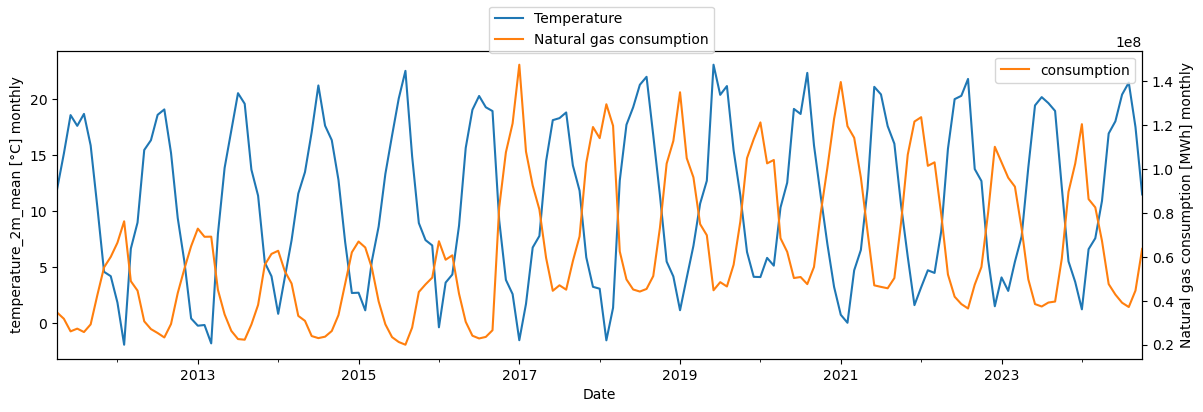

In [12]:
fig, ax1 = plt.subplots(figsize=(14, 4))
ax2 = ax1.twinx()

# For both, only show data in 2021 and 2022
temp_2m_mean_monthly.plot(ax=ax1, color="tab:blue")
gas_consumption_monthly.plot(ax=ax2, color="tab:orange")

# Labels and legend
ax1.set_ylabel("temperature_2m_mean [°C] monthly")
ax2.set_ylabel("Natural gas consumption [MWh] monthly")

# Legend for both plots in one
fig.legend(
    labels=["Temperature", "Natural gas consumption"],

    loc="upper center",
)

# Create directory if it does not exist
os.makedirs("diagrams", exist_ok=True)

# Save plot
fig.savefig("diagrams/temp_conso_monthly.svg", format="svg", bbox_inches="tight")

## Filtered post 2017 

In [64]:
gas_consumption_monthly.index = pd.to_datetime(gas_consumption_monthly.index)
temp_2m_mean_monthly.index = pd.to_datetime(temp_2m_mean_monthly.index)
# Filtrer les données à partir de 2017 inclusivement
gas_consumption_monthly_filtered = gas_consumption_monthly[gas_consumption_monthly.index >= "2017-01-01"]
temp_2m_mean_monthly_filtered = temp_2m_mean_monthly[temp_2m_mean_monthly.index >= "2017-01-01"]

consumption_data.index = pd.to_datetime(consumption_data.index)
temp_2m_mean.index = pd.to_datetime(temp_2m_mean.index)
# Filtrer les données à partir de 2017 inclusivement
consumption_data_filtered = consumption_data[consumption_data.index >= "2017-01-01"]
temp_2m_mean_filtered = temp_2m_mean[temp_2m_mean.index >= "2017-01-01"]

In [65]:
#Nb d'heures ou 1m2 recoit plus de 120 Watts 
sunshine_dur = weather["sunshine_duration (h)"]
sunshine_dur = sunshine_dur.loc[start_date:end_date]
sunshine_dur.index = pd.to_datetime(sunshine_dur.index)
# Filtrer les données à partir de 2017 inclusivement
sunshine_dur_filtered = sunshine_dur[sunshine_dur.index >= "2017-01-01"]
sunshine_dur_filtered

Date
2017-01-01    2.127367
2017-01-02    3.982603
2017-01-03    0.000000
2017-01-04    2.736236
2017-01-05    6.287208
                ...   
2024-10-27    5.493553
2024-10-28    2.000000
2024-10-29    0.000000
2024-10-30    2.199706
2024-10-31    2.540353
Name: sunshine_duration (h), Length: 2861, dtype: float64

In [66]:
#Nb de secondes ou 1m2 recoit plus de 120 Watts 
wind_speed_10m_max = weather["wind_speed_10m_max (km/h)"]
wind_speed_10m_max = wind_speed_10m_max.loc[start_date:end_date]
wind_speed_10m_max.index = pd.to_datetime(wind_speed_10m_max.index)
# Filtrer les données à partir de 2017 inclusivement
wind_speed_10m_max_filtered = wind_speed_10m_max[wind_speed_10m_max.index >= "2017-01-01"]
wind_speed_10m_max_filtered

Date
2017-01-01    17.8
2017-01-02    20.3
2017-01-03    35.9
2017-01-04    38.9
2017-01-05    23.0
              ... 
2024-10-27    22.5
2024-10-28    17.4
2024-10-29    16.4
2024-10-30    18.5
2024-10-31    21.9
Name: wind_speed_10m_max (km/h), Length: 2861, dtype: float64

In [68]:
sunshine_dur_monthly = sunshine_dur.resample('M').mean()
wind_speed_10m_max_monthly = wind_speed_10m_max.resample('M').mean()

wind_speed_10m_max_monthly.index = pd.to_datetime(wind_speed_10m_max_monthly.index)
# Filtrer les données à partir de 2017 inclusivement
wind_speed_10m_max_monthly_filtered = wind_speed_10m_max_monthly[wind_speed_10m_max_monthly.index >= "2017-01-01"]
wind_speed_10m_max_monthly_filtered

sunshine_dur_monthly.index = pd.to_datetime(sunshine_dur_monthly.index)
# Filtrer les données à partir de 2017 inclusivement
sunshine_dur_monthly_filtered = sunshine_dur_monthly[sunshine_dur_monthly.index >= "2017-01-01"]
sunshine_dur_monthly_filtered

Date
2017-01-31     3.039155
2017-02-28     4.300701
2017-03-31     6.795422
2017-04-30     9.039270
2017-05-31     9.164912
                ...    
2024-06-30    11.845321
2024-07-31    11.427107
2024-08-31    11.297771
2024-09-30     8.687915
2024-10-31     5.998683
Freq: M, Name: sunshine_duration (h), Length: 94, dtype: float64

In [87]:
#Filtrage sur l'hiver

cold_months = [1, 2, 3, 10, 11, 12]

# Filtrer sur les mois froids pour les deux séries
gas_consumption_cold_months = gas_consumption_monthly_filtered[gas_consumption_monthly_filtered.index.month.isin(cold_months)]
temp_2m_mean_cold_months = temp_2m_mean_monthly_filtered[temp_2m_mean_monthly_filtered.index.month.isin(cold_months)]

#### Correlation daily and monthly temperature 

In [70]:
consumption_data_filtered.corr(temp_2m_mean_filtered)

-0.9216492442816219

In [71]:
gas_consumption_monthly['consumption'].corr(temp_2m_mean_monthly_filtered)

-0.9577167381885309

In [72]:
gas_consumption_monthly_filtered['consumption'].corr(sunshine_dur_monthly_filtered)

-0.8586761108151125

In [73]:
gas_consumption_monthly_filtered['consumption'].corr(wind_speed_10m_max_monthly_filtered)

0.30358898943078555

In [107]:
consumption_data_filtered.corr(wind_speed_10m_max_filtered)

0.04061447110155235

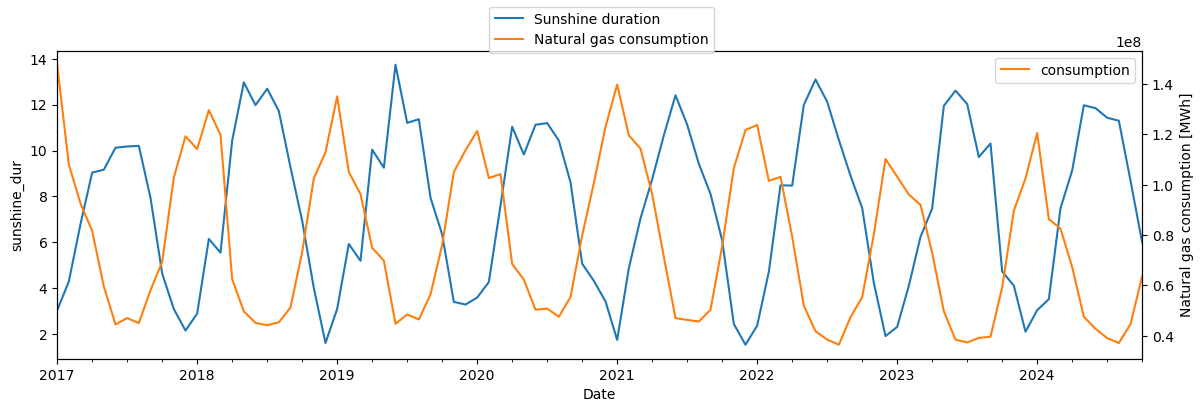

In [74]:
fig, ax1 = plt.subplots(figsize=(14, 4))
ax2 = ax1.twinx()

sunshine_dur_monthly_filtered.plot(ax=ax1, color="tab:blue")
gas_consumption_monthly_filtered.plot(ax=ax2, color="tab:orange")

ax1.set_ylabel("sunshine_dur")
ax2.set_ylabel("Natural gas consumption [MWh]")

fig.legend(
    labels=["Sunshine duration", "Natural gas consumption"],

    loc="upper center",
)

os.makedirs("diagrams", exist_ok=True)

# Save plot
fig.savefig("diagrams/sunshine_duration_analysis.svg", format="svg", bbox_inches="tight")

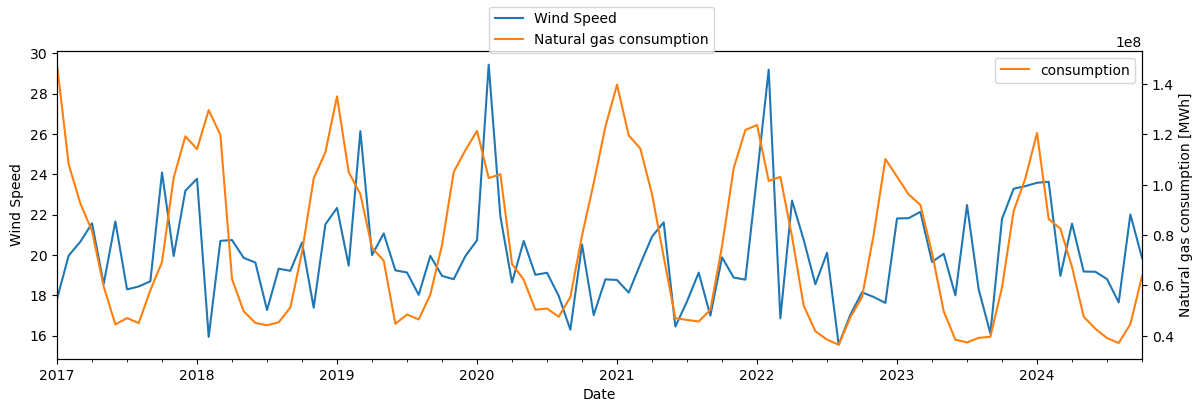

In [75]:
fig, ax1 = plt.subplots(figsize=(14, 4))
ax2 = ax1.twinx()

wind_speed_10m_max_monthly_filtered.plot(ax=ax1, color="tab:blue")
gas_consumption_monthly_filtered.plot(ax=ax2, color="tab:orange")

ax1.set_ylabel("Wind Speed")
ax2.set_ylabel("Natural gas consumption [MWh]")

fig.legend(
    labels=["Wind Speed", "Natural gas consumption"],

    loc="upper center",
)

os.makedirs("diagrams", exist_ok=True)

# Save plot
fig.savefig("diagrams/wind_speed_analysis.svg", format="svg", bbox_inches="tight")

## Stationnarity analysis

In [38]:
#The goal is to see if we can improve the correlation by removing the trending/seasonality effect by making the time series stationnary

#gas_consumption_monthly = gas_consumption_monthly.fillna(method='ffill')
gas_consumption_monthly_st = make_series_stationary(gas_consumption_monthly['consumption'])

#wind_speed_10m_max_monthly = wind_speed_10m_max_monthly.fillna(method='ffill')
wind_speed_10m_max_monthly_st = make_series_stationary(wind_speed_10m_max_monthly)

#sunshine_dur_monthly = sunshine_dur_monthly.fillna(method='ffill')
sunshine_dur_monthly_st = make_series_stationary(sunshine_dur_monthly)


In [39]:
temp_2m_mean_monthly_st = make_series_stationary(temp_2m_mean_monthly)

In [40]:
temp_2m_mean_monthly_st

Date
2011-04-30         NaN
2011-05-31    3.128280
2011-06-30    3.435054
2011-07-31   -0.957634
2011-08-31    1.064516
                ...   
2024-06-30    1.088172
2024-07-31    2.386022
2024-08-31    1.067742
2024-09-30   -3.960430
2024-10-31   -6.013763
Freq: M, Name: temperature_2m_mean (°C), Length: 163, dtype: float64

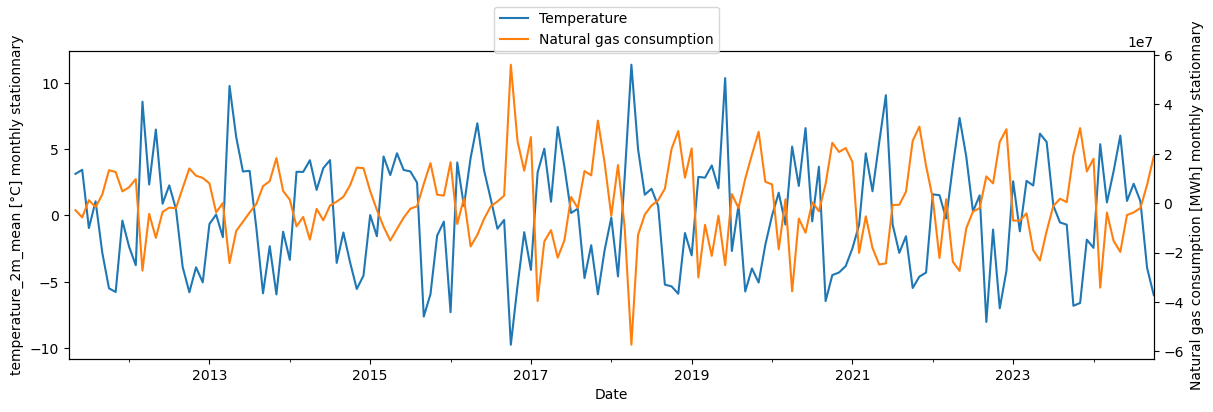

In [41]:
fig, ax1 = plt.subplots(figsize=(14, 4))
ax2 = ax1.twinx()

# For both, only show data in 2021 and 2022
temp_2m_mean_monthly_st.plot(ax=ax1, color="tab:blue")
gas_consumption_monthly_st.plot(ax=ax2, color="tab:orange")

# Labels and legend
ax1.set_ylabel("temperature_2m_mean [°C] monthly stationnary")
ax2.set_ylabel("Natural gas consumption [MWh] monthly stationnary")

# Legend for both plots in one
fig.legend(
    labels=["Temperature", "Natural gas consumption"],

    loc="upper center",
)

# Create directory if it does not exist
os.makedirs("diagrams", exist_ok=True)

# Save plot
fig.savefig("diagrams/temp_conso_monthly_stationnary.svg", format="svg", bbox_inches="tight")

In [42]:
gas_consumption_monthly_st.corr(temp_2m_mean_monthly_st)

-0.8605553305766885

## Linear Regression

In [77]:
train_size = 0.8  # 80% pour l'entraînement, 20% pour le test
train, test = train_test_split(pd.concat([gas_consumption_monthly_filtered, temp_2m_mean_monthly_filtered,sunshine_dur_monthly_filtered,wind_speed_10m_max_monthly_filtered], axis=1), 
                               test_size=1-train_size, shuffle=False)

X_test = test['temperature_2m_mean (°C)'].values.reshape(-1, 1)
y_test = test['consumption'].values



X_train = train['temperature_2m_mean (°C)'].values.reshape(-1, 1)  # Température comme variable indépendante
y_train = train['consumption'].values  # Consommation de gaz comme cible

model = LinearRegression()
model.fit(X_train, y_train)

# Prédictions sur le test set
y_pred = model.predict(X_test)

# Calcul de la MSE pour cette régression
mse = mean_squared_error(y_test, y_pred)
print(f'MSE (temp_2m_mean_monthly -> gas_consumption_monthly): {mse}')
r2 = model.score(X_test, y_test)
print(f'R^2 (temp_2m_mean_monthly -> gas_consumption_monthly): {r2}')


MSE (temp_2m_mean_monthly -> gas_consumption_monthly): 96982783517099.98
R^2 (temp_2m_mean_monthly -> gas_consumption_monthly): 0.8374406621361095


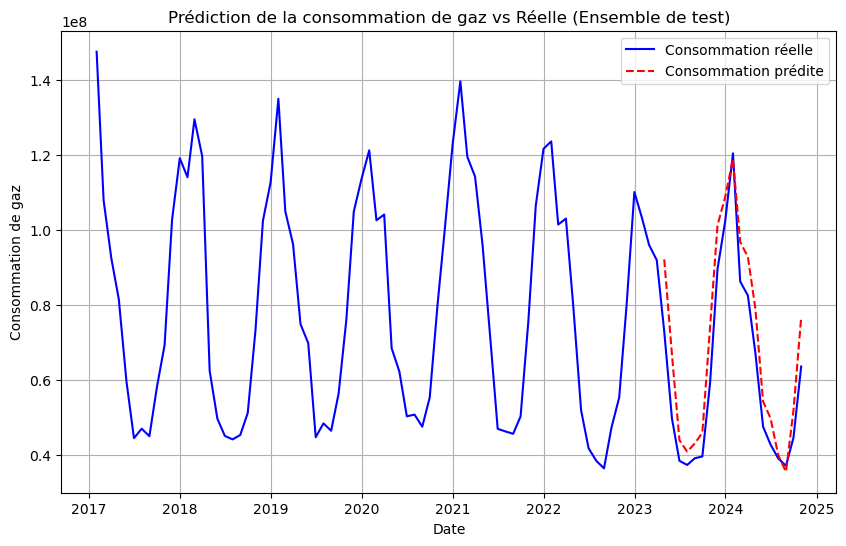

In [79]:
plt.figure(figsize=(10, 6))
plt.plot(gas_consumption_monthly_filtered.index, gas_consumption_monthly_filtered, label='Consommation réelle', color='blue')
plt.plot(test.index, y_pred, label='Consommation prédite', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Consommation de gaz')
plt.title('Prédiction de la consommation de gaz vs Réelle (Ensemble de test)')
plt.legend()
plt.grid(True)
plt.show()


## Ridge Regression

In [95]:
# Définir la taille de l'ensemble d'entraînement
train_size = 0.8  # 80% pour l'entraînement, 20% pour le test

# Diviser les données en ensembles d'entraînement et de test
train, test = train_test_split(
    pd.concat([gas_consumption_monthly_filtered, temp_2m_mean_monthly_filtered, sunshine_dur_monthly_filtered], axis=1),
    test_size=1 - train_size, shuffle=False
)

X_train = train[['temperature_2m_mean (°C)', 'sunshine_duration (h)']].values
y_train = train['consumption'].values

X_test = test[['temperature_2m_mean (°C)', 'sunshine_duration (h)']].values
y_test = test['consumption'].values

model = make_pipeline(
    MinMaxScaler(),
    Ridge(alpha=1.0)
)

# Entraîner le modèle sur l'ensemble d'entraînement
model.fit(X_train, y_train)

# Prédire les valeurs de consommation sur l'ensemble de test
y_pred = model.predict(X_test)

# Calculer l'erreur quadratique moyenne (MSE) sur l'ensemble de test
mse = mean_squared_error(y_test, y_pred)
print(f'MSE (Ridge Regression avec MinMaxScaler): {mse}')

# Calculer le coefficient de détermination R^2 sur l'ensemble de test
r2 = r2_score(y_test, y_pred)
print(f'R^2 (Ridge Regression avec MinMaxScaler): {r2}')


MSE (Ridge Regression avec MinMaxScaler): 128159399972565.0
R^2 (Ridge Regression avec MinMaxScaler): 0.785183447566234


In [96]:
y_pred

array([8.77088870e+07, 6.02205653e+07, 4.39967407e+07, 4.35306208e+07,
       5.07668137e+07, 5.11200288e+07, 8.31115498e+07, 1.02030362e+08,
       1.11911997e+08, 1.15979336e+08, 1.00659662e+08, 8.80872185e+07,
       7.51746517e+07, 5.21922261e+07, 4.96519084e+07, 4.44384358e+07,
       4.19592363e+07, 5.89666301e+07, 8.15712278e+07])

In [97]:
y_test

array([7.29756024e+07, 4.97766001e+07, 3.84933410e+07, 3.73841396e+07,
       3.91971075e+07, 3.96407850e+07, 5.92261635e+07, 8.96464917e+07,
       1.02512740e+08, 1.20523277e+08, 8.63518360e+07, 8.25755915e+07,
       6.73080242e+07, 4.76038905e+07, 4.28268358e+07, 3.91059369e+07,
       3.71550955e+07, 4.46444230e+07, 6.36528502e+07])

In [98]:
# Récupérer les coefficients du modèle
coefficients = model.named_steps['ridge'].coef_

scaler = model.named_steps['minmaxscaler']
min_values = scaler.data_min_
ranges = scaler.data_range_


coefficients_original_scale = coefficients / ranges


for feature, coef in zip(['temperature_2m_mean (°C)', 'sunshine_dur_monthly', 'wind_speed_10m_max_monthly'], coefficients_original_scale):
    print(f'Coefficient pour {feature}: {coef}')


Coefficient pour temperature_2m_mean (°C): -2628172.197187011
Coefficient pour sunshine_dur_monthly: -2528376.9604239142


## Linear Regression Using Statsmodel

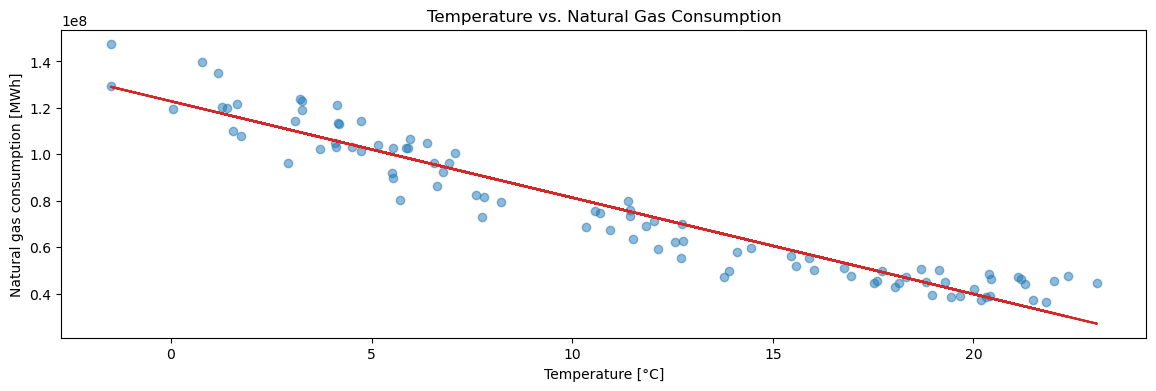

In [112]:
linear_regression = stats.linregress(temp_2m_mean_monthly_filtered, gas_consumption_monthly_filtered['consumption'])

#Plot linear regression
regression_y = linear_regression.slope * temp_2m_mean_monthly_filtered + linear_regression.intercept

#Scatter plot of temperature and natural gas consumption
fig, ax = plt.subplots(figsize=(14, 4))
ax.scatter(temp_2m_mean_monthly_filtered, gas_consumption_monthly_filtered['consumption'], alpha=0.5)

#Plot linear regression
ax.plot(temp_2m_mean_monthly_filtered, regression_y, color="tab:red")

#Labels and legend
ax.set_xlabel("Temperature [°C]")
ax.set_ylabel("Natural gas consumption [MWh]")
ax.set_title("Temperature vs. Natural Gas Consumption")

#Save plot
fig.savefig("diagrams/reglin.svg", format="svg", bbox_inches="tight")


In [113]:
print(f"R-squared: {linear_regression.rvalue**2:.6f}")

R-squared: 0.917221


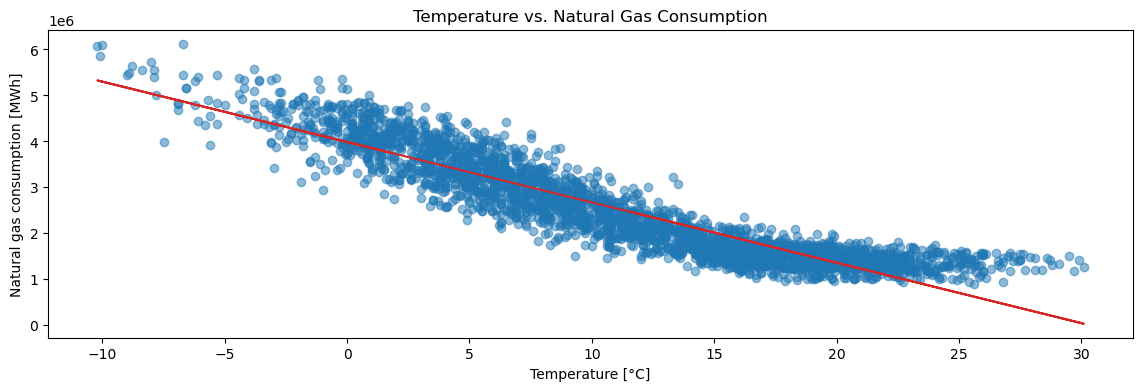

In [85]:
linear_regression = stats.linregress(temp_2m_mean_filtered, consumption_data_filtered)

#Plot linear regression
regression_y = linear_regression.slope * temp_2m_mean_filtered + linear_regression.intercept

#Scatter plot of temperature and natural gas consumption
fig, ax = plt.subplots(figsize=(14, 4))
ax.scatter(temp_2m_mean_filtered, consumption_data_filtered, alpha=0.5)

#Plot linear regression
ax.plot(temp_2m_mean_filtered, regression_y, color="tab:red")

#Labels and legend
ax.set_xlabel("Temperature [°C]")
ax.set_ylabel("Natural gas consumption [MWh]")
ax.set_title("Temperature vs. Natural Gas Consumption")

#Save plot
fig.savefig("diagrams/reglin_daily.svg", format="svg", bbox_inches="tight")


In [86]:
print(f"R-squared daily: {linear_regression.rvalue**2:.6f}")

R-squared daily: 0.849437


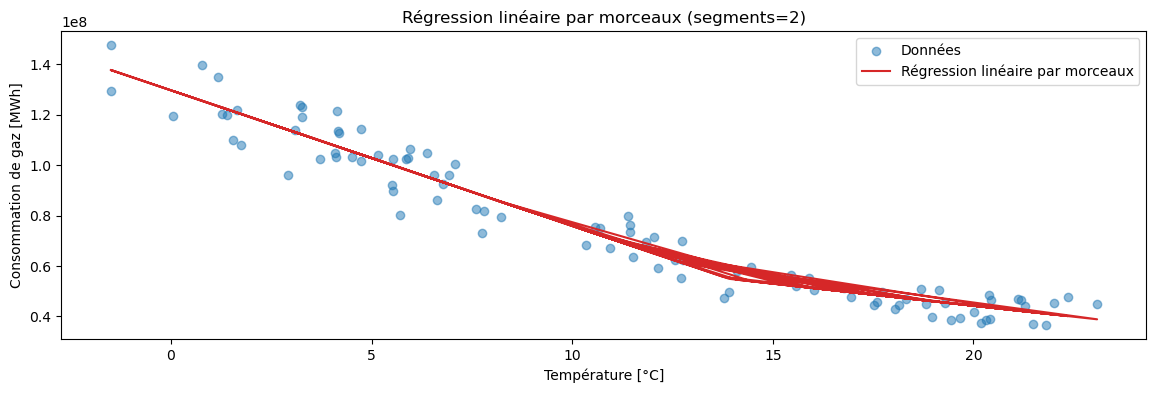

0.9486787802957546


In [84]:
X = temp_2m_mean_monthly_filtered.values
y = gas_consumption_monthly_filtered['consumption'].values

# Initialiser le modèle Piecewise Linear Fit
model = pwlf.PiecewiseLinFit(X, y)

# Choisir le nombre de segments (par exemple, 2 segments ici)
num_segments = 2
model.fit(num_segments)

# Prédictions
y_pred = model.predict(X)

# Tracer les données et la régression linéaire par morceaux
fig, ax = plt.subplots(figsize=(14, 4))
ax.scatter(X, y, alpha=0.5, label="Données")
ax.plot(X, y_pred, color="tab:red", label="Régression linéaire par morceaux")

# Ajouter des labels et une légende
ax.set_xlabel("Température [°C]")
ax.set_ylabel("Consommation de gaz [MWh]")
ax.set_title(f"Régression linéaire par morceaux (segments={num_segments})")
ax.legend()

# Sauvegarder le graphique
fig.savefig("diagrams/piecewise_regression_pwlf.svg", format="svg", bbox_inches="tight")

# Afficher le graphique
plt.show()

rsq = model.r_squared()
print(rsq)

## Regression Multiple

                            OLS Regression Results                            
Dep. Variable:            consumption   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     528.6
Date:                Thu, 09 Jan 2025   Prob (F-statistic):           8.04e-51
Time:                        15:07:00   Log-Likelihood:                -1633.5
No. Observations:                  94   AIC:                             3273.
Df Residuals:                      91   BIC:                             3281.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1.257e+08   2.19e+0

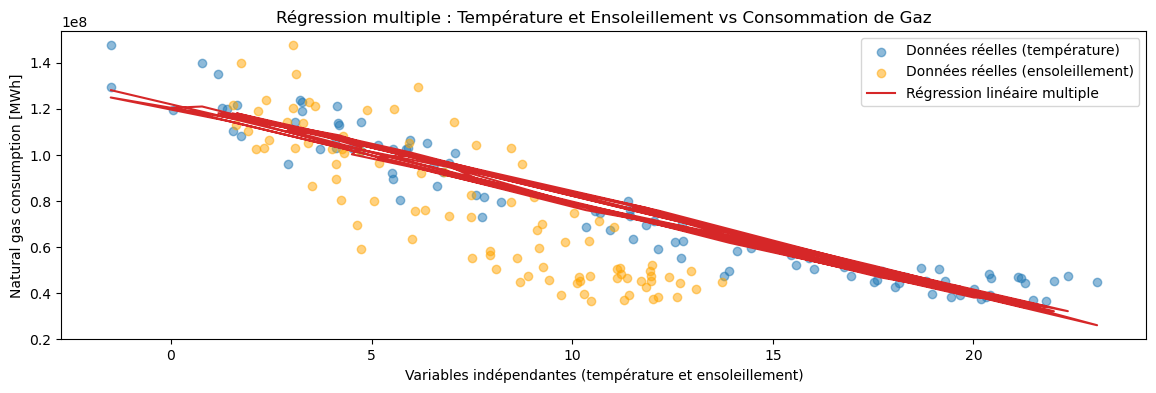

In [103]:
# Préparer les variables indépendantes (température et durée d'ensoleillement)
X = pd.DataFrame({
    'temperature': temp_2m_mean_monthly_filtered,
    'sunshine_duration': sunshine_dur_monthly_filtered
})

# Ajouter une constante pour le terme d'interception
X = sm.add_constant(X)

# Préparer la variable dépendante (consommation de gaz)
y = gas_consumption_monthly_filtered['consumption']

# Ajuster un modèle de régression linéaire multiple
model = sm.OLS(y, X).fit()

# Résumé du modèle
print(model.summary())

# Prédire les valeurs de consommation
y_pred = model.predict(X)

# Calcul manuel du R² ajusté
n = len(y)  # Nombre d'observations
k = X.shape[1] - 1  # Nombre de variables explicatives (sans la constante)
r2 = model.rsquared
r2_adjusted = model.rsquared_adj

# Affichage des résultats
print(f"R² : {r2}")
print(f"R² ajusté : {r2_adjusted}")

# Scatter plot pour la visualisation des données et prédictions
fig, ax = plt.subplots(figsize=(14, 4))
ax.scatter(temp_2m_mean_monthly_filtered, y, alpha=0.5, label="Données réelles (température)")
ax.scatter(sunshine_dur_monthly_filtered, y, alpha=0.5, label="Données réelles (ensoleillement)", color="orange")
ax.plot(temp_2m_mean_monthly_filtered, y_pred, color="tab:red", label="Régression linéaire multiple")
ax.set_xlabel("Variables indépendantes (température et ensoleillement)")
ax.set_ylabel("Natural gas consumption [MWh]")
ax.set_title("Régression multiple : Température et Ensoleillement vs Consommation de Gaz")
ax.legend()

# Enregistrer le graphique
fig.savefig("diagrams/reglin_multiple.svg", format="svg", bbox_inches="tight")

MSE (Ridge Regression): 72723277017464.66
R² : 0.9207467237053092
R² ajusté : 0.9190048934570743


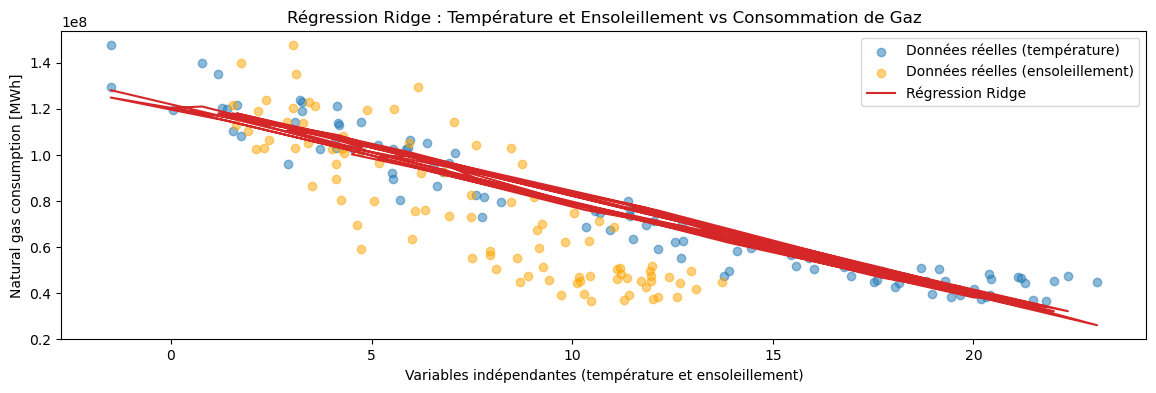

In [108]:
X = pd.DataFrame({
    'temperature': temp_2m_mean_monthly_filtered,
    'sunshine_duration': sunshine_dur_monthly_filtered
}).values  # Convertir en tableau NumPy si nécessaire

# Préparer la variable dépendante (consommation de gaz)
y = gas_consumption_monthly_filtered['consumption'].values

# Ajuster un modèle de régression Ridge
ridge_model = Ridge(alpha=1.0)  # alpha est le paramètre de régularisation
ridge_model.fit(X, y)

# Prédire les valeurs de consommation
y_pred = ridge_model.predict(X)

# Calcul manuel du R² ajusté
n = len(y)  # Nombre d'observations
k = X.shape[1]  # Nombre de variables explicatives
r2 = r2_score(y, y_pred)
r2_adjusted = 1 - ((1 - r2) * (n - 1)) / (n - k - 1)

# Calcul de la MSE
mse = mean_squared_error(y, y_pred)

# Affichage des résultats
print(f"MSE (Ridge Regression): {mse}")
print(f"R² : {r2}")
print(f"R² ajusté : {r2_adjusted}")

# Scatter plot pour la visualisation des données et prédictions
fig, ax = plt.subplots(figsize=(14, 4))
ax.scatter(temp_2m_mean_monthly_filtered, y, alpha=0.5, label="Données réelles (température)")
ax.scatter(sunshine_dur_monthly_filtered, y, alpha=0.5, label="Données réelles (ensoleillement)", color="orange")
ax.plot(temp_2m_mean_monthly_filtered, y_pred, color="tab:red", label="Régression Ridge")
ax.set_xlabel("Variables indépendantes (température et ensoleillement)")
ax.set_ylabel("Natural gas consumption [MWh]")
ax.set_title("Régression Ridge : Température et Ensoleillement vs Consommation de Gaz")
ax.legend()

# Enregistrer le graphique
fig.savefig("diagrams/ridge_regression.svg", format="svg", bbox_inches="tight")


## Winter Regression

In [88]:
temp_2m_mean_cold_months 

Date
2017-01-31    -1.490323
2017-02-28     1.750000
2017-03-31     6.777419
2017-10-31    11.845161
2017-11-30     5.900000
2017-12-31     3.270968
2018-01-31     3.103226
2018-02-28    -1.500000
2018-03-31     1.396774
2018-10-31    11.432258
2018-11-30     5.523333
2018-12-31     4.196774
2019-01-31     1.183871
2019-02-28     4.085714
2019-03-31     6.929032
2019-10-31    11.438710
2019-11-30     6.376667
2019-12-31     4.161290
2020-01-31     4.141935
2020-02-29     5.851724
2020-03-31     5.158065
2020-10-31    11.393548
2020-11-30     7.086667
2020-12-31     3.264516
2021-01-31     0.777419
2021-02-28     0.064286
2021-03-31     4.741935
2021-10-31    10.564516
2021-11-30     5.950000
2021-12-31     1.638710
2022-01-31     3.225806
2022-02-28     4.746429
2022-03-31     4.509677
2022-10-31    12.706452
2022-11-30     5.703333
2022-12-31     1.535484
2023-01-31     4.109677
2023-02-28     2.907143
2023-03-31     5.506452
2023-10-31    12.141935
2023-11-30     5.540000
2023-12-31 

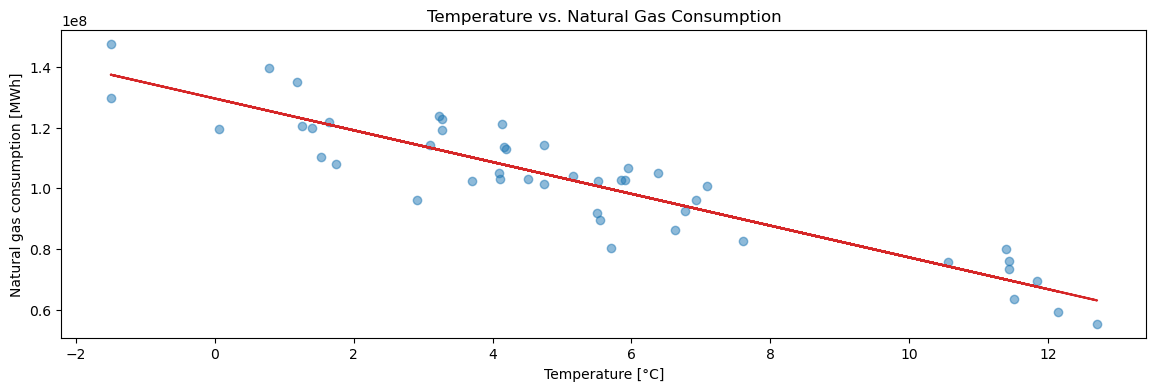

In [89]:
linear_regression = stats.linregress(temp_2m_mean_cold_months, gas_consumption_cold_months['consumption'])

#Plot linear regression
regression_y = linear_regression.slope * temp_2m_mean_cold_months + linear_regression.intercept

#Scatter plot of temperature and natural gas consumption
fig, ax = plt.subplots(figsize=(14, 4))
ax.scatter(temp_2m_mean_cold_months, gas_consumption_cold_months['consumption'], alpha=0.5)

#Plot linear regression
ax.plot(temp_2m_mean_cold_months, regression_y, color="tab:red")

#Labels and legend
ax.set_xlabel("Temperature [°C]")
ax.set_ylabel("Natural gas consumption [MWh]")
ax.set_title("Temperature vs. Natural Gas Consumption")

#Save plot
fig.savefig("diagrams/reglin.svg", format="svg", bbox_inches="tight")


In [90]:
print(f"R-squared: {linear_regression.rvalue**2:.6f}")

R-squared: 0.837733


## SARIMAX (with Exogenous factors being the temperature)

C:\Users\Ali\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


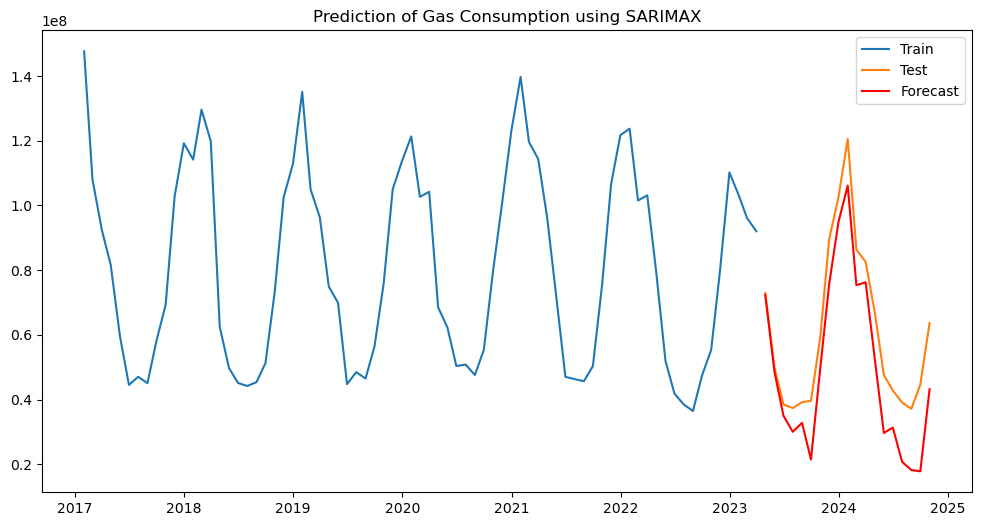

In [91]:
train_size = 0.8  # 80% pour l'entraînement, 20% pour le test
train, test = train_test_split(pd.concat([gas_consumption_monthly_filtered, temp_2m_mean_monthly_filtered], axis=1), 
                               test_size=1-train_size, shuffle=False)



# Variables exogènes pour le modèle
train_exog = train[['temperature_2m_mean (°C)']]
test_exog = test[['temperature_2m_mean (°C)']]

# Création et ajustement du modèle SARIMAX
model = SARIMAX(
    train['consumption'],
    exog=train_exog,
    order=(1, 1, 1),  
    seasonal_order=(1, 1, 1, 12)  # Ordre saisonnier (P, D, Q, s)
)
results = model.fit()

# Prédictions
forecast = results.predict(start=len(train), end=len(train) + len(test) - 1, exog=test_exog)

# Affichage des résultats
plt.figure(figsize=(12, 6))
plt.plot(train['consumption'], label="Train")
plt.plot(test['consumption'], label="Test")
plt.plot(forecast, label="Forecast", color='red')
plt.legend()
plt.title("Prediction of Gas Consumption using SARIMAX")
plt.show()

In [92]:
mse = mean_squared_error(test['consumption'], forecast)
mse

191395983863644.9

In [93]:
forecast

2023-04-30    7.235483e+07
2023-05-31    4.846914e+07
2023-06-30    3.500988e+07
2023-07-31    3.005243e+07
2023-08-31    3.281206e+07
2023-09-30    2.149656e+07
2023-10-31    4.960367e+07
2023-11-30    7.573156e+07
2023-12-31    9.486466e+07
2024-01-31    1.061181e+08
2024-02-29    7.536649e+07
2024-03-31    7.623969e+07
2024-04-30    5.304674e+07
2024-05-31    2.968902e+07
2024-06-30    3.135590e+07
2024-07-31    2.079538e+07
2024-08-31    1.823103e+07
2024-09-30    1.785262e+07
2024-10-31    4.319775e+07
Freq: M, Name: predicted_mean, dtype: float64

In [94]:
test['consumption']

2023-04-30    7.297560e+07
2023-05-31    4.977660e+07
2023-06-30    3.849334e+07
2023-07-31    3.738414e+07
2023-08-31    3.919711e+07
2023-09-30    3.964079e+07
2023-10-31    5.922616e+07
2023-11-30    8.964649e+07
2023-12-31    1.025127e+08
2024-01-31    1.205233e+08
2024-02-29    8.635184e+07
2024-03-31    8.257559e+07
2024-04-30    6.730802e+07
2024-05-31    4.760389e+07
2024-06-30    4.282684e+07
2024-07-31    3.910594e+07
2024-08-31    3.715510e+07
2024-09-30    4.464442e+07
2024-10-31    6.365285e+07
Freq: M, Name: consumption, dtype: float64

## Logarithm Regression

                            OLS Regression Results                            
Dep. Variable:            consumption   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     1063.
Date:                Thu, 09 Jan 2025   Prob (F-statistic):           2.43e-52
Time:                        15:37:42   Log-Likelihood:                -1633.7
No. Observations:                  94   AIC:                             3271.
Df Residuals:                      92   BIC:                             3277.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

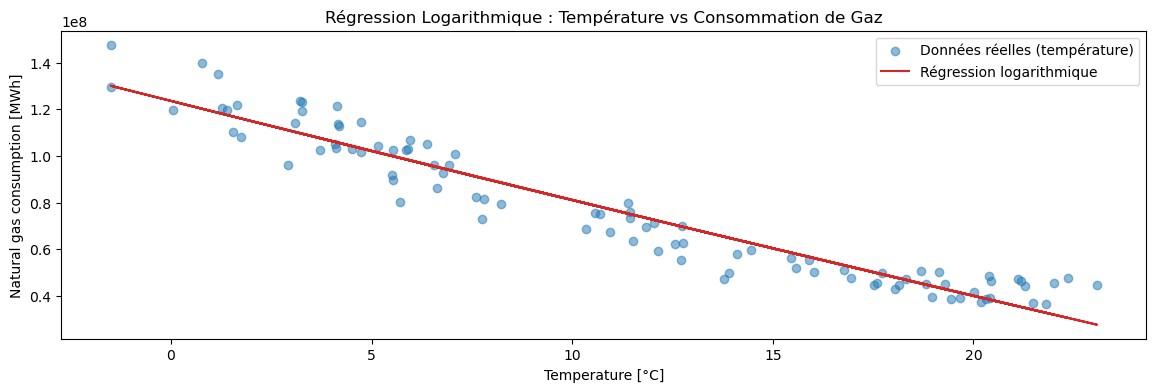

In [109]:
# Conversion de la température en Kelvin (Temp[K] = Temp[°C] + 273.15)
temp_kelvin = temp_2m_mean_monthly_filtered + 273.15

# Calcul du logarithme de la température en Kelvin
log_temp = np.log(temp_kelvin)

# Préparer la variable indépendante (logarithme de la température)
X = log_temp

# Préparer la variable dépendante (consommation de gaz)
y = gas_consumption_monthly_filtered['consumption']

# Ajuster un modèle de régression linéaire simple sur log(Temp) vs Consommation
linear_regression = sm.OLS(y, sm.add_constant(X)).fit()

# Résumé du modèle
print(linear_regression.summary())

# Prédire les valeurs de consommation
y_pred = linear_regression.predict(sm.add_constant(X))

# Scatter plot pour la visualisation des données et des prédictions
fig, ax = plt.subplots(figsize=(14, 4))
ax.scatter(temp_2m_mean_monthly_filtered, y, alpha=0.5, label="Données réelles (température)")
ax.plot(temp_2m_mean_monthly_filtered, y_pred, color="tab:red", label="Régression logarithmique")
ax.set_xlabel("Temperature [°C]")
ax.set_ylabel("Natural gas consumption [MWh]")
ax.set_title("Régression Logarithmique : Température vs Consommation de Gaz")
ax.legend()

# Enregistrer le graphique
fig.savefig("diagrams/log_regression.svg", format="svg", bbox_inches="tight")


In [115]:
log_temp

Date
2017-01-31    5.604550
2017-02-28    5.616407
2017-03-31    5.634530
2017-04-30    5.638200
2017-05-31    5.661632
                ...   
2024-06-30    5.673953
2024-07-31    5.682114
2024-08-31    5.685744
2024-09-30    5.672212
2024-10-31    5.651306
Freq: M, Name: temperature_2m_mean (°C), Length: 94, dtype: float64